Atividade final da disciplina de Visão Robótica

Discente: Henrique Antônio Guanais Corneau

# Reconstrução 3D a partir do mapa de disparidade

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from measure_distance import DistanceMeter
from gps_mark import GPSMarker

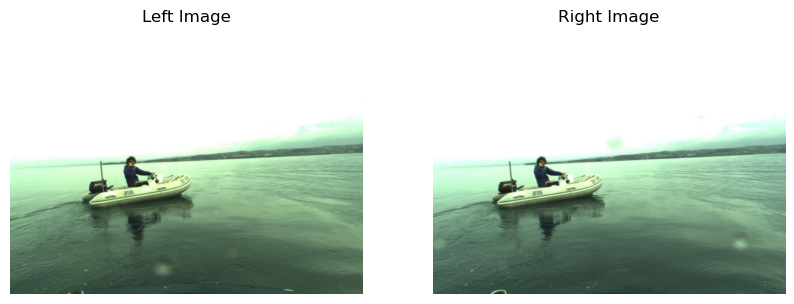

In [2]:
# imagem esquerda e direita
left_image = cv2.imread("../dataset/MODD/frames/00013824L.jpg")
right_image = cv2.imread("../dataset/MODD/frames/00013824R.jpg")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB))
plt.title('Left Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB))
plt.title('Right Image')
plt.axis('off')
plt.show()

In [3]:
# obter os parametros de calibracao da camera a partir do arquivo de calibracao
calibration_dir = "../dataset/MODD/calibration.yaml"
calibration_file = cv2.FileStorage(calibration_dir, cv2.FILE_STORAGE_READ)
Kl = np.array(calibration_file.getNode('M1').mat())
Dl = np.array(calibration_file.getNode('D1').mat())
Kr = np.array(calibration_file.getNode('M2').mat())
Dr = np.array(calibration_file.getNode('D2').mat())
R = np.array(calibration_file.getNode('R').mat())
T = np.array(calibration_file.getNode('T').mat())   
calibration_file.release()

print('Left camera:')
print(Kl)
print('Left camera distortion:')
print(Dl)
print('Right camera:')
print(Kr)
print('Right camera distortion:')
print(Dr)
print('Rotation matrix:')
print(R)
print('Translation:')
print(T)

Left camera:
[[957.7950706    0.         656.23724898]
 [  0.         956.99355408 538.41903131]
 [  0.           0.           1.        ]]
Left camera distortion:
[[-3.67679344e-01]
 [ 2.03381397e-01]
 [ 2.07905790e-04]
 [ 4.68656691e-04]
 [-7.56255767e-02]]
Right camera:
[[957.1114608    0.         641.71133185]
 [  0.         956.12071851 502.87401404]
 [  0.           0.           1.        ]]
Right camera distortion:
[[-3.66992989e-01]
 [ 2.05628665e-01]
 [ 2.41385031e-04]
 [-3.40254028e-04]
 [-7.92577706e-02]]
Rotation matrix:
[[ 9.99959238e-01  1.20322305e-04 -9.02818929e-03]
 [-8.24866241e-05  9.99991214e-01  4.19109356e-03]
 [ 9.02861425e-03 -4.19017801e-03  9.99950462e-01]]
Translation:
[[-356.38806655]
 [  -0.52120595]
 [  -2.66188526]]


458 553
639 479


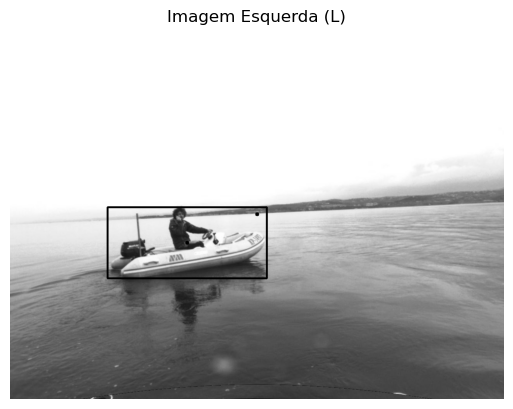

In [4]:
focal_length = Kl[0, 0]  
baseline = T[0, 0] / -1000

x, y, w, h = 252, 461, 412, 184
center_x = x + w/2
center_y = y + h/2
magnetic_declination = 4.41
print(int(center_x), int(center_y))

imgL = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
imgR = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)
print(int(imgL.shape[1]/2), int(imgL.shape[0]/2))

stereo_method_file = "../dataset/MODD/stereo-method.yaml"
gps_path = '../dataset/MODD/gps.txt'
imu_path = '../dataset/MODD/imu.txt'

imgL_temp = np.copy(imgL)
cv2.rectangle(imgL_temp, (x, y), (x+w, y+h), (0, 0, 255), 3)
cv2.circle(imgL_temp, (int(center_x), int(center_y)), 5, (0, 0, 255), -1)
cv2.circle(imgL_temp, (int(imgL_temp.shape[1]/2), int(imgL_temp.shape[0]/2)), 5, (0, 0, 255), -1)
plt.imshow(cv2.cvtColor(imgL_temp, cv2.COLOR_BGR2RGB))
plt.title("Imagem Esquerda (L)")
plt.axis('off')
plt.show()

Distância estimada na região (252:664, 461:645) é: 15.54 metros
Profundidade mínima: 2.69 m
Profundidade máxima: 682.69 m


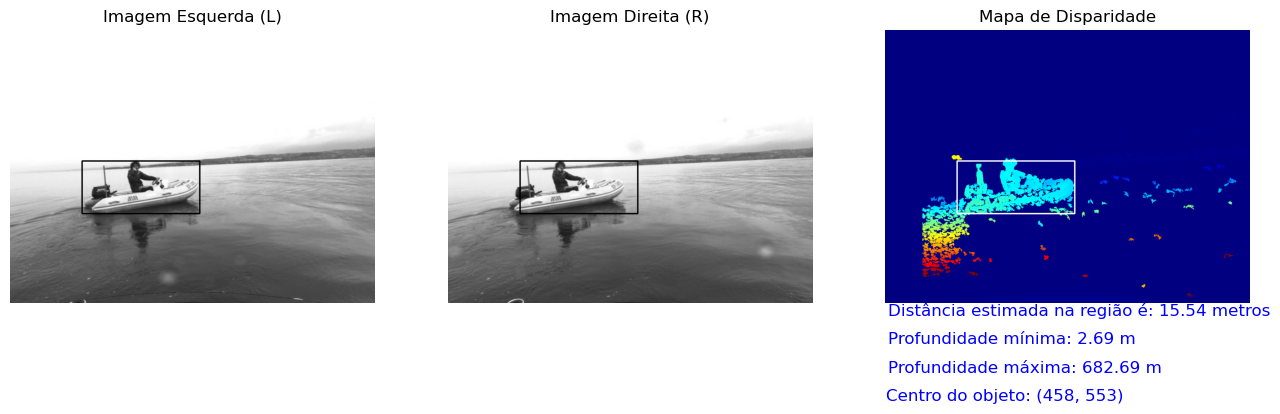

-10.701313570379291
36.69913261659958
9.284746020940016 12.456835962932418
Coordenadas do barco: 45.54761966523571, 13.705387316093407
Coordenadas do objeto: 45.54772494613465, 13.705468087391244


In [5]:
# cria e o plota o mapa de disparidade, calculando a distancia ate determinado objeto
distance_meter = DistanceMeter(focal_length, baseline)
distance_meter.load_stereo_params(stereo_method_file)
distance_meter.disparity_compute(imgL, imgR, (x, y), (w, h))
distance_meter.plot_results(plot_extreme_points=False)

# descobre as coordenadas do objeto em relacao ao barco
gps_marker = GPSMarker(magnetic_declination)
gps_marker.angle_object(center_x, distance_meter.depth, imgL, focal_length)
obj_latitude, obj_longitude = gps_marker.gps_mark(gps_path, imu_path)

print(f"Coordenadas do barco: {gps_marker.boat_coords[0]}, {gps_marker.boat_coords[1]}")
print(f"Coordenadas do objeto: {gps_marker.obj_coords[0]}, {gps_marker.obj_coords[1]}")

In [6]:
def create_output(vertices, colors, filename):
	"""
	Função que cria um arquivo .ply da nuvem de pontos.

	Parâmetros:	
		vertices: coordenadas 3D dos pontos
		colors: cor dos pontos
		filename: nome do arquivo .ply
	"""

	# redimensiona o vetor de cores e de pontos
	colors = colors.reshape(-1, 3)
	vertices = np.hstack([vertices.reshape(-1, 3), colors])
	# define o cabeçalho do arquivo .ply
	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	# escreve o arquivo .ply
	with open(filename, 'w') as f:
		f.write(ply_header % dict(vert_num=len(vertices)))
		np.savetxt(f, vertices, '%f %f %f %d %d %d')

In [7]:
depth_map_gray = cv2.cvtColor(distance_meter.disparity_normalize, cv2.COLOR_BGR2GRAY)
_, _, _, _, Q, _, _ = cv2.stereoRectify(Kl, Dl, Kr, Dr, (left_image.shape[1], left_image.shape[0]), R, T)
roi = depth_map_gray[y:y+h, x:x+w]
points_3D = cv2.reprojectImageTo3D(depth_map_gray, Q)
roi_3D = cv2.reprojectImageTo3D(roi, Q)

# Remove INF values from point cloud
points_3D[points_3D == float('+inf')] = 0
points_3D[points_3D == float('-inf')] = 0
roi_3D[roi_3D == float('+inf')] = 0
roi_3D[roi_3D == float('-inf')] = 0

# Get rid of points with value 0 (i.e no depth)
mask_map = depth_map_gray > depth_map_gray.min()
mask_map_roi = roi > roi.min()
# Mask colors and points
colors = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
output_points = points_3D[mask_map]/1000
roi_points = roi_3D[mask_map_roi]/1000
output_colors = colors[mask_map]

# Generate point cloud
output_file = 'point_cloud1.ply'
create_output(output_points, output_colors, output_file)

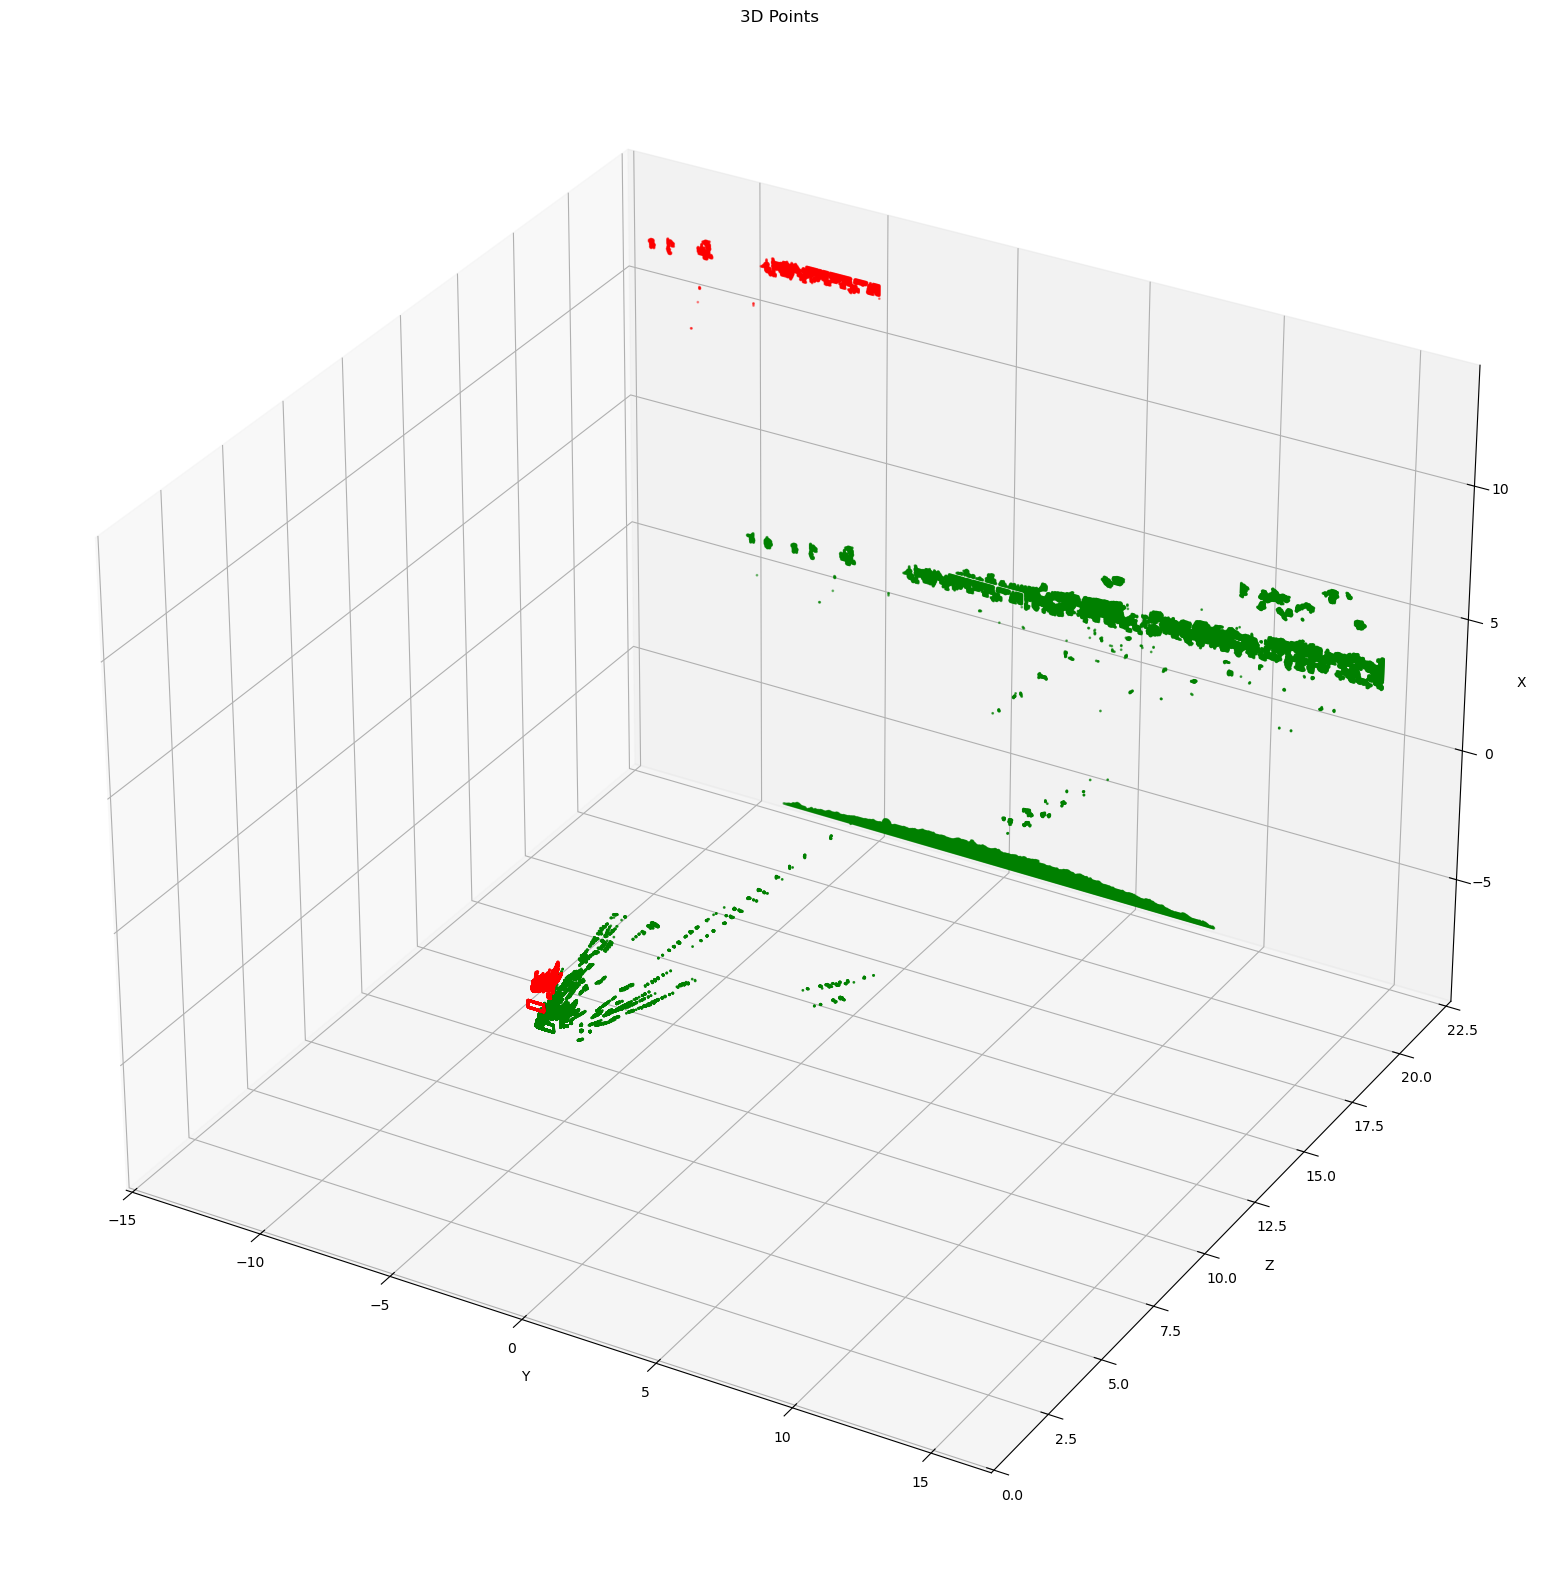

In [9]:

# Plot the 3D points
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')

ax.scatter(output_points[:, 0], output_points[:, 2], -output_points[:, 1], s=1, c='g')
ax.scatter(roi_points[:, 0], roi_points[:, 2], -roi_points[:, 1], s=1, c='r')
plt.title('3D Points')
ax.set_xlabel('Y')
ax.set_ylabel('Z')
ax.set_zlabel('X')
plt.show()